In [1]:
import os

# 设置默认编码为UTF-8
os.environ['PYTHONIOENCODING'] = 'utf-8'

# 加载api_key等环境变量
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# 提示词

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import lead_researcher_prompt

show_prompt(lead_researcher_prompt, "Lead Researcher Prompt")

╭──────────────────────────────────────────── Lead Researcher Prompt ─────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research supervisor. Your job is to conduct research by calling the "ConductResearch" tool. For      │
│  context, today's date is {date}.                                                                               │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your focus is to call the "ConductResearch" tool to conduct research against the overall research question     │
│  passed in by the user.                                                                                         │
│  When you are completely satisfied with the research findings returned from the tool calls, then you should     │
│  call the "ResearchComplete" tool to indicate that you are done with your research.                             │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to three main tools:                                                                           │
│  1. **ConductResearch**: Delegate research tasks to specialized sub-agents                                      │
│  2. **ResearchComplete**: Indicate that research is complete                                                    │
│  3. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool before calling ConductResearch to plan your approach, and after each                │
│  ConductResearch to assess progress**                                                                           │
│  **PARALLEL RESEARCH**: When you identify multiple independent sub-topics that can be explored simultaneously,  │
│  make multiple ConductResearch tool calls in a single response to enable parallel research execution. This is   │
│  more efficient than sequential research for comparative or multi-faceted questions. Use at most                │
│  {max_concurrent_research_units} parallel agents per iteration.                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a research manager with limited time and resources. Follow these steps:                             │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Decide how to delegate the research** - Carefully consider the question and decide how to delegate the    │
│  research. Are there multiple independent directions that can be explored simultaneously?                       │
│  3. **After each call to ConductResearch, pause and assess** - Do I have enough to answer? What's still         │
│  missing?                                                                                                       │
│  </Instructions>                                      

# State

In [3]:
%%writefile deep_research_from_scratch/state_multi_agent_supervisor.py

"""Multi-Agent Supervisor State"""

import operator
from typing_extensions import Annotated, TypedDict, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    """Supervisor State"""

    # 用于在supervisor和researcher之间传递消息
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    # 研究简报
    research_brief: str
    # 用于最终报告生成的要点信息
    notes: Annotated[list[str], operator.add] = []
    # 记录迭代次数
    research_iterations: int = 0
    # 原始的来自sub-agent的研究要点
    raw_notes: Annotated[list[str], operator.add] = []

# 这里定义的tool只是用于定义工具的类型（状态记录），而不是用于执行工具
@tool
class ConductResearch(BaseModel):
    """分发工具，用于分发研究任务给researcher"""
    research_topic: str = Field(
        description="The Topic to research. Should be a single topic, and should be described in high detail (at least a paragraph).",
    )

@tool
class ResearchComplete(BaseModel):
    """研究完成工具，用于指示研究过程完成
    
    当所有研究任务都完成后调用此工具。
    不需要任何参数，调用本身就表示研究结束。
    """
    pass


Overwriting deep_research_from_scratch/state_multi_agent_supervisor.py


# Multi-Agent

In [4]:
%%writefile deep_research_from_scratch/multi_agent_supervisor.py

"""协调多agent的研究监督者(Multi-Agent Supervisor)"""

import os
import asyncio

from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import (
    HumanMessage,
    BaseMessage,
    SystemMessage,
    ToolMessage,
    filter_messages
)
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

from deep_research_from_scratch.prompts import lead_researcher_prompt
from deep_research_from_scratch.research_agent import researcher_agent
from deep_research_from_scratch.state_multi_agent_supervisor import (
    SupervisorState,
    ConductResearch,
    ResearchComplete
)
from deep_research_from_scratch.utils import get_today_str, think_tool

def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """从supervisor的messages中提取出tool_calls中的研究要点信息(包括总结后的研究报告)"""
    return [tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")]

# 用于notebook中的异步执行
try:
    import nest_asyncio
    # 仅在notebook中使用
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass  # 在其他环境中运行时，忽略此错误
except ImportError:
    pass

# ==== 配置 ====

supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
# 模型初始化
api_url = os.getenv('KIMI_API_URL')
api_key = os.getenv('KIMI_API_KEY')
model_name = os.getenv('KIMI_MODEL')
supervisor_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    # max_tokens=64000
)
# 绑定工具
supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

# 最大迭代次数(工具调用次数)
max_researcher_iterations = 6

# 最大并行研究数
max_concurrent_researchers = 3

# ==== supervisor节点 ====

async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    """协调research过程"""
    supervisor_messages = state.get("supervisor_messages", [])

    # system message
    system_message = lead_researcher_prompt.format(
        date=get_today_str(),
        max_concurrent_research_units=max_concurrent_researchers,
        max_researcher_iterations=max_researcher_iterations
    )
    messages = [SystemMessage(content=system_message)] + supervisor_messages

    # 决定下一步做什么
    response = await supervisor_model_with_tools.ainvoke(messages)

    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1
        }
    )

async def supervisor_tools(state: SupervisorState) -> Command[Literal["supervisor", END]]:
    """supervisor工具节点,执行工具调用"""
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)
    most_recent_message = supervisor_messages[-1]

    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"  # 默认下一步是supervisor
    should_end = False

    # 添加调试信息
    print(f"🔍 当前迭代次数: {research_iterations}, 最大限制: {max_researcher_iterations}")
    print(f"🔍 最新消息是否有tool_calls: {bool(most_recent_message.tool_calls)}")

    # 优先判断是否需要结束
    exceeded_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not most_recent_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete"
        for tool_call in most_recent_message.tool_calls
    )

    print(f"🔍 超过迭代限制: {exceeded_iterations}")
    print(f"🔍 没有tool_calls: {no_tool_calls}")
    print(f"🔍 研究完成: {research_complete}")

    if exceeded_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
        print(f"✅ 满足结束条件，准备结束流程")
    else:
        print(f"➡️ 继续执行，下一步: {next_step}")
        print(f"🔍 当前消息: {most_recent_message}")
        # 工具执行
        try:
            # 分离tool调用
            think_tool_calls = [
                tool_call for tool_call in most_recent_message.tool_calls
                if tool_call["name"] == "think_tool"
            ]

            conduct_research_calls = [
                tool_call for tool_call in most_recent_message.tool_calls
                if tool_call["name"] == "ConductResearch"
            ]

            # 执行think_tool调用(同步执行)
            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    )
                )
            
            # 执行conduct_research调用(异步执行)
            if conduct_research_calls:
                # 并发执行sub-agent
                coros = [
                    researcher_agent.ainvoke({
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"]
                    })
                    for tool_call in conduct_research_calls
                ]

                # 等待所有异步执行完成
                tool_results = await asyncio.gather(*coros)

                # 提取总结的研究报告
                research_tool_messages = [
                    ToolMessage(
                        content=result.get("compressed_research", "Error synthesizing research report"),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"]
                    ) for result, tool_call in zip(tool_results, conduct_research_calls)
                ]

                tool_messages.extend(research_tool_messages)

                # 合并raw_notes
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", []))
                    for result in tool_results
                ]
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END

    if should_end:
        return Command(
            goto=next_step,
            update={
                "notes": get_notes_from_tool_calls(supervisor_messages),
                "research_brief": state.get("research_brief", "")
            }
        )
    else:
        return Command(
            goto=next_step,
            update={
                "supervisor_messages": tool_messages,
                "raw_notes": all_raw_notes
            }
        )

# ==== 构建工作流 ====

# 构建supervisor的graph
# 添加节点
supervisor_builder = StateGraph(SupervisorState)
supervisor_builder.add_node("supervisor", supervisor)
supervisor_builder.add_node("supervisor_tools", supervisor_tools)

# 添加边
supervisor_builder.add_edge(START, "supervisor")

# 编译
supervisor_agent = supervisor_builder.compile()

Overwriting deep_research_from_scratch/multi_agent_supervisor.py


# 可视化

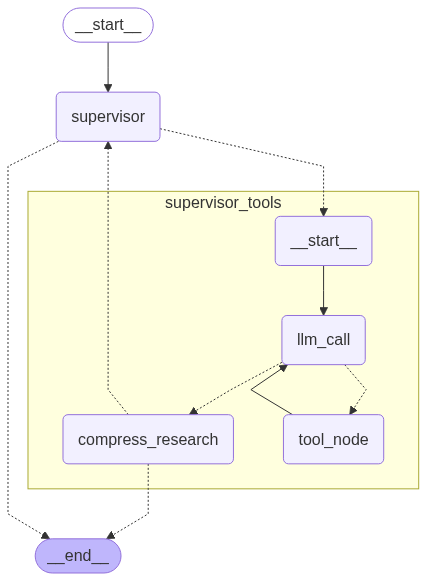

In [5]:
from IPython.display import Image, display
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

display(Image(supervisor_agent.get_graph(xray=True).draw_mermaid_png()))

# 运行工作流

In [ ]:
from utils import format_messages
from langchain_core.messages import HumanMessage

research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

# config = {"recursion_limit": 50}
result = await supervisor_agent.ainvoke(
    {"supervisor_messages": [HumanMessage(content=research_brief)]},
    # config=config
)
format_messages(result["supervisor_messages"])

🔍 当前迭代次数: 1, 最大限制: 6
🔍 最新消息是否有tool_calls: True
🔍 超过迭代限制: False
🔍 没有tool_calls: False
🔍 研究完成: False
➡️ 继续执行，下一步: supervisor
🔍 当前消息: content="I'll help you identify and evaluate the best coffee shops in San Francisco based specifically on coffee quality. Let me start by planning this research systematically." additional_kwargs={'tool_calls': [{'id': 'think_tool:0', 'function': {'arguments': '{"reflection": "The user wants a comprehensive evaluation of San Francisco coffee shops based solely on coffee quality. This requires:\\n\\n1. Identifying top-rated coffee shops in SF based on coffee quality metrics\\n2. Using multiple assessment methods: expert reviews, specialty certifications, customer ratings focused on coffee\\n3. Prioritizing primary sources: official websites, Coffee Review, SCA, Google/Yelp reviews specifically about coffee quality\\n4. Creating a well-supported ranking/list\\n\\nI should break this into parallel research streams:\\n- Expert reviews and specialty coffee ratin

# 评估

In [ ]:
# 测试样例
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

should_parallelize = [
    HumanMessage(content="Compare OpenAI vs Gemini deep research."),
    AIMessage(content="I need to analyze this request to determine if can should be parallelized.", tool_calls=[
        {
            "name": "think_tool",
            "args": {"reflection": "This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research."},
            "id": "call_think_1"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a comparison task involving two distinct AI products: OpenAI v Gemini Deep Research.", tool_call_id="call_think_1", name="think_tool")
]

should_not_parallelize = [
    HumanMessage(content="What are the top three Chinese restaurants in Chelsea, Manhattan"),
    AIMessage(content="Let me think about whether this task requires parallelization.", tool_calls=[
        {
            "name": "think_tool", 
            "args": {"reflection": "This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan)."},
            "id": "call_think_2"
        }
    ]),
    ToolMessage(content="Analysis complete: This is a ranking/listing task for restaurants in a specific geographic area (Chelsea, Manhattan).", tool_call_id="call_think_2", name="think_tool")
]

In [ ]:
# 构建数据集
import os
from langsmith import Client

# Initialize client 
langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_supervisor_parallelism"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a supervisor can accurately decide when to parallelize research.",
    )

    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"supervisor_messages": should_parallelize},
                "outputs": {"num_expected_threads": 2},
            },
            {
                "inputs": {"supervisor_messages": should_not_parallelize},
                "outputs": {"num_expected_threads": 1},
            },
        ],
    )

In [ ]:
# 运行测试
import uuid

def evaluate_parallelism(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["output"].update["supervisor_messages"][-1].tool_calls
    return {
        "key": "correct_next_step",
        "score": len(tool_calls) == reference_outputs["num_expected_threads"]
    }

async def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    return await supervisor_agent.nodes["supervisor"].ainvoke(inputs, config=config)

await langsmith_client.aevaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_parallelism],
    experiment_prefix="Supervisor Parallelism",
)

View the evaluation results for experiment: 'Supervisor Parallelism-f92311ef' at:
https://smith.langchain.com/o/eb8bebb5-7e5c-489b-8a33-b1f12a101f70/datasets/79fae521-c1e6-400d-be68-d2888042bc13/compare?selectedSessions=6176ed4a-549d-48ab-b61b-cde39c80ebc5




0it [00:00, ?it/s]

<AsyncExperimentResults Supervisor Parallelism-f92311ef>